**W207 Project - Convolution Neural Networks**

In [129]:
# === Import Modules
import numpy as np
import pandas as pd
from keras import metrics
from tensorflow import keras
from keras import regularizers
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.constraints import maxnorm
from tensorflow.keras.layers import ConvLSTM2D
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.utils import class_weight

**Data Load**

In [130]:
# === Import processed_data
source_data = np.load("F:/Coding Projects/Data_Spell_Workspace/project_w207_video_process/Dataset/Process_3_Matrix_Conversion/cnnlstm_dataset_crop.npy",allow_pickle=True)
# === print download
print("Loading Completed")

Loading Completed


**Data Panel Construct**

In [131]:
# Convert NPY into Dataframes and print head(5)
df = pd.DataFrame(columns=["image","label","Actor","label_value"])
for i in range(0,len(source_data)):
    df.loc[len(df)+1] = [source_data[i][0], source_data[i][1], source_data[i][2], source_data[i][3]]
print(df.head())

                                               image label Actor  label_value
1  [[[[4 8 9], [3 7 8], [3 8 7], [4 9 8], [4 10 9...     a    DC            0
2  [[[[4 8 9], [4 8 9], [6 8 8], [7 9 9], [9 10 8...     a    DC            0
3  [[[[6 8 8], [7 9 9], [5 10 9], [5 10 9], [4 11...     a    DC            0
4  [[[[6 7 11], [6 8 9], [5 10 8], [5 11 6], [4 1...     a    DC            0
5  [[[[4 8 9], [4 9 8], [6 8 8], [7 10 8], [7 10 ...     a    DC            0


**Input Data Processing**

In [132]:
# === Stratified Dataset Train/Test Split
sgkf = StratifiedKFold(n_splits=4, shuffle=True, random_state=10)
for train_index, val_index in sgkf.split(df.image, df.label_value):
    train_x, test_x = df.image.iloc[train_index], df.image.iloc[val_index]
    train_y, test_y = df.label_value.iloc[train_index], df.label_value.iloc[val_index]

# === Convert df.columns into list
train_x = [i for i in train_x]
test_x = [i for i in test_x]
train_y = [i for i in train_y]
test_y = [i for i in test_y]

# === Convert list into arrays
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

# === Tensor Convert
train_x = K.cast_to_floatx(train_x)
train_y = K.cast_to_floatx(train_y)
test_x = K.cast_to_floatx(test_x)
test_y = K.cast_to_floatx(test_y)
confusion_test_y = test_y # copy a test_y for confustion matrix
class_weight_y = train_y
# === Normalization
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x = train_x / 255.0
test_x = test_x / 255.0

# === One-hot Encoding
train_y = np_utils.to_categorical(train_y)
test_y = np_utils.to_categorical(test_y)
class_num = test_y.shape[1]

# === print result
print("train_x: ", len(train_x))
print("train_y: ", len(train_y))
print("test_x: ", len(test_x))
print("test_y: ", len(test_y))

train_x:  360
train_y:  360
test_x:  120
test_y:  120


**Convolutional LSTM Neural Networks**

**Model Architecture**

In [133]:
# ***** Convolutional Neural Networks - LSTM
# === Initial model construction
model = Sequential()

# === ConvLSTM2D Layer (Filter = 64, kernel_size = 5*5)
model.add(ConvLSTM2D(filters=32, kernel_size=(5, 5),input_shape = (6,64,64,3),activation='relu'))
model.add(BatchNormalization())

# === Conv2D Layer (Filter = 32, kernel_size = 3*3)
model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))
model.add(BatchNormalization())

# === Flatten Layer
model.add(Flatten())
# model.add(Dropout(0.2))

# === Full Connectivity Layer + Regularization
model.add(Dense(16, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
# model.add(Dropout(0.2))
model.add(BatchNormalization())

# === Output Layer
model.add(Dense(class_num))
model.add(Activation('softmax'))

# === Optimizer setuyp and Model Compile
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
print(model.summary())

class_weights = class_weight.compute_class_weight(class_weight="balanced",classes=np.unique(class_weight_y),y = class_weight_y)
class_weight_dict = dict(zip([x for x in np.unique(class_weight_y)], class_weights))

# === Fit model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=60, batch_size=20,class_weight=class_weight_dict)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_18 (ConvLSTM2D)  (None, 60, 60, 32)       112128    
                                                                 
 batch_normalization_56 (Bat  (None, 60, 60, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 58, 58, 16)        4624      
                                                                 
 activation_56 (Activation)  (None, 58, 58, 16)        0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 29, 29, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_57 (Bat  (None, 29, 29, 16)     

**Model Evaluation**

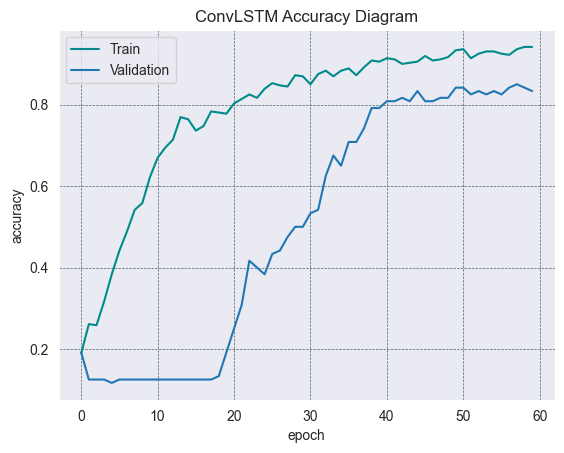

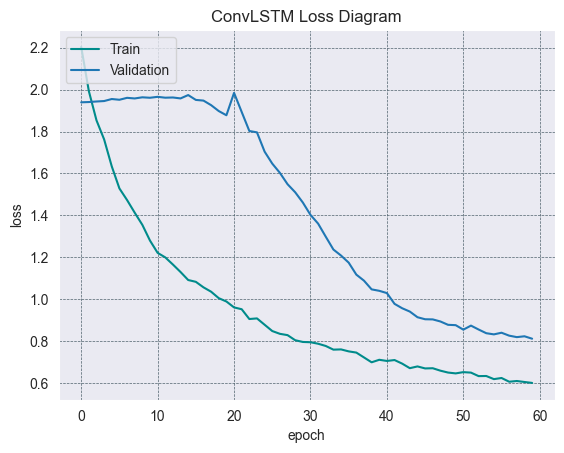

In [134]:
# === Summarize history for accuracy
plt.plot(history.history['accuracy'],c ="darkcyan")
plt.plot(history.history['val_accuracy'])
plt.title('ConvLSTM Accuracy Diagram')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(ls = "--", lw = 0.5, color = "#4E616C")
plt.show()
# === Summarize history for loss
plt.plot(history.history['loss'],c ="darkcyan")
plt.plot(history.history['val_loss'])
plt.title('ConvLSTM Loss Diagram')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(ls = "--", lw = 0.5, color = "#4E616C")
plt.show()

4/4 [==============================] - 0s 35ms/step


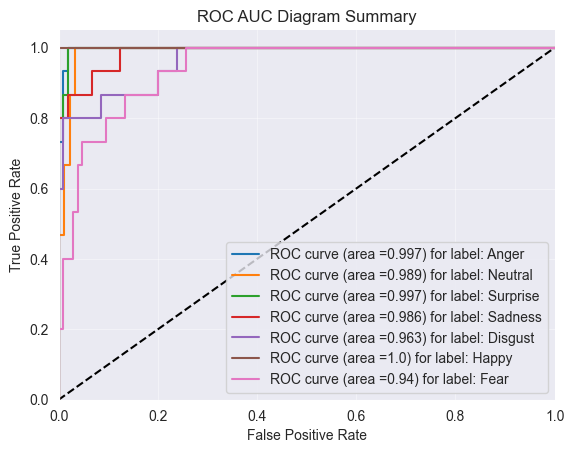

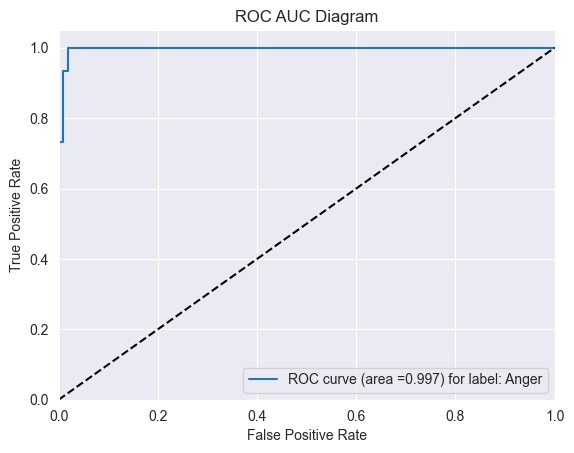

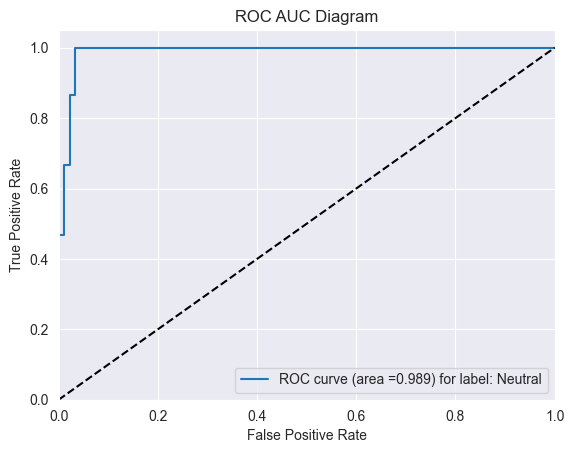

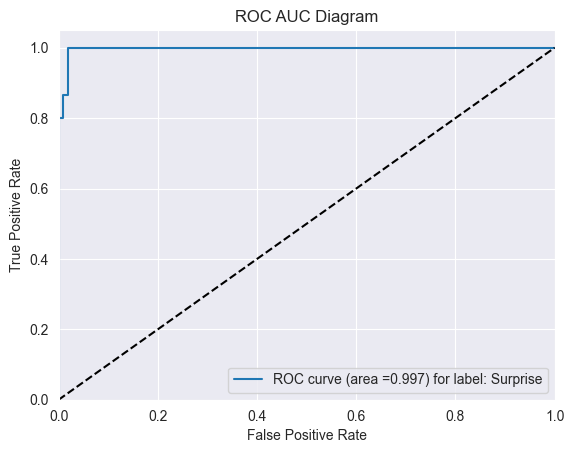

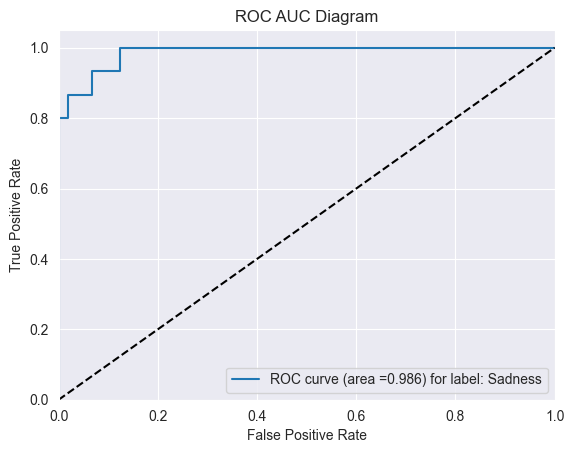

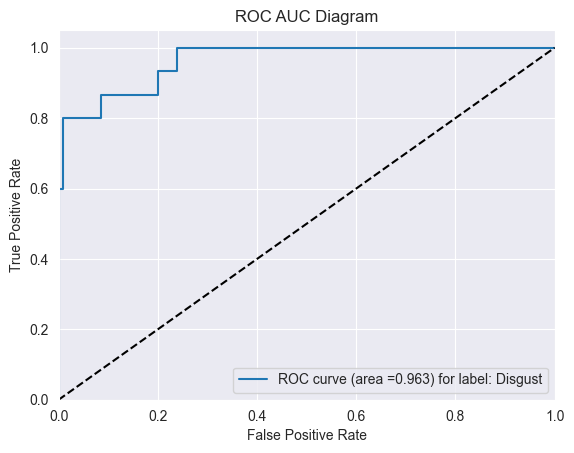

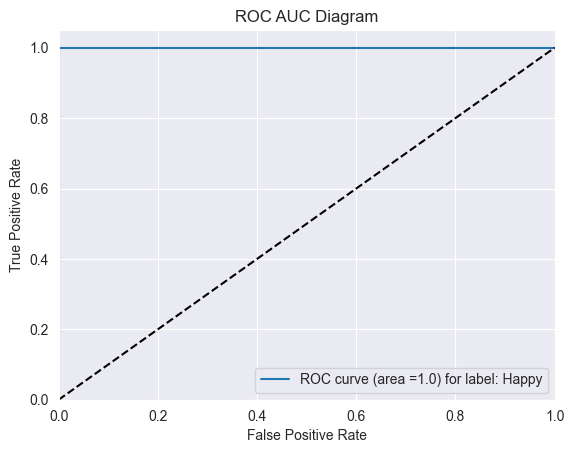

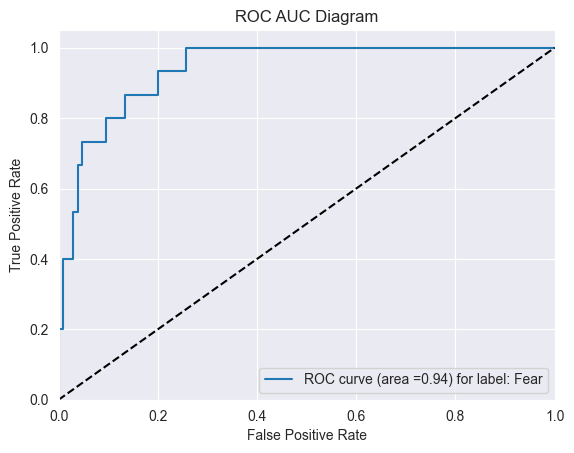

In [135]:
# === Compute ROC curve and ROC area for each class
y_test_pred = model.predict(test_x)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

label_dict = {"Anger":0,"Neutral":1,"Surprise":2,"Sadness":3,"Disgust":4,"Happy":5,"Fear":6}
label_name = {v:k for k,v in label_dict.items()}
# Plot in one diagram
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC AUC Diagram Summary')
for i in range(7):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area ='+str(round(roc_auc[i],3))+') for label: '+label_name[i])
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()

# Plot AUC ROC individually
for i in range(7):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area ='+str(round(roc_auc[i],3))+') for label: '+label_name[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Diagram')
    plt.legend(loc="lower right")

**Confusion Matrix**

4/4 [==============================] - 0s 36ms/step
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90        15
         1.0       0.91      0.97      0.94        30
         2.0       0.93      0.93      0.93        15
         3.0       0.58      0.93      0.72        15
         4.0       0.92      0.73      0.81        15
         5.0       0.88      1.00      0.94        15
         6.0       0.75      0.20      0.32        15

    accuracy                           0.83       120
   macro avg       0.84      0.81      0.79       120
weighted avg       0.84      0.83      0.81       120



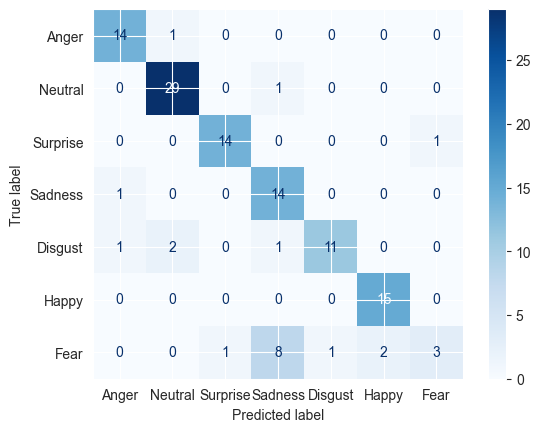

In [136]:
#  === Print confusion matrix
y_test_pred = model.predict(test_x)
y_test_pred = np.argmax(y_test_pred, axis=1)
# Classification Report
print(classification_report(confusion_test_y, y_test_pred))
# Confusiont Matrix
target_names = ["Anger","Neutral","Surprise","Sadness","Disgust","Happy","Fear"]
cm_display = ConfusionMatrixDisplay.from_predictions(confusion_test_y, y_test_pred, display_labels=target_names,cmap = 'Blues')